# Token vs. Sentence Embeddings

In [1]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

from transformers import BertModel, BertTokenizer
from datasets import load_dataset

## Helper Functions and Setup

In [5]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

def get_sentence_embedding(sentence):
    encoded_input = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')
    attention_mask = encoded_input['attention_mask']   # to indicate which tokens are valid and which are padding
    
    # Get the model output (without the specific classification head)
    with torch.no_grad():
        output = model(**encoded_input)

    token_embeddings = output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

    # mean pooling operation, considering the BERT input_mask and padding
    sentence_embedding = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    return sentence_embedding.flatten().tolist()

In [6]:
def cosine_similarity_matrix(features):
    norms = np.linalg.norm(features, axis=1, keepdims=True)
    normalized_features = features / norms
    similarity_matrix = np.inner(normalized_features, normalized_features)
    rounded_similarity_matrix = np.round(similarity_matrix, 4)
    return rounded_similarity_matrix

In [7]:
# Helper function to plot similarity matrix
def plot_similarity(labels, features, rotation):
    sim = cosine_similarity_matrix(features)
    sns.set_theme(font_scale=1.2)
    g = sns.heatmap(sim, xticklabels=labels, yticklabels=labels, vmin=0, vmax=1, cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")
    return g

## Token Embeddings

In [8]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

<AxesSubplot:title={'center':'Semantic Textual Similarity'}>

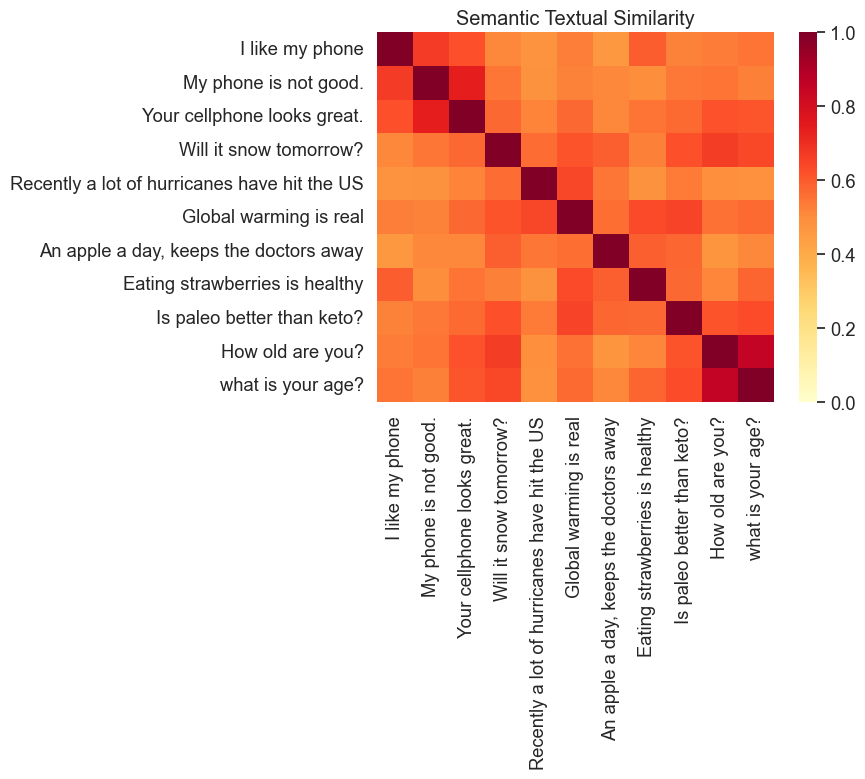

In [9]:
embeddings = []
for t in messages:
    emb = get_sentence_embedding(t)
    embeddings.append(emb)

plot_similarity(messages, embeddings, 90)

In [10]:
sts_dataset = load_dataset("mteb/stsbenchmark-sts")
sts = pd.DataFrame({'sent1': sts_dataset['test']['sentence1'], 
                    'sent2': sts_dataset['test']['sentence2'],
                    'score': [x/5 for x in sts_dataset['test']['score']]})
sts.head(10)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

,sent1,sent2,score
0,A girl is styling her hair.,A girl is brushing her hair.,0.5000
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,0.7200
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,1.0000
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,0.8400
4,A man is playing a harp.,A man is playing a keyboard.,0.3000
5,A woman is cutting onions.,A woman is cutting tofu.,0.3600
6,A man is riding an electric bicycle.,A man is riding a bicycle.,0.7000
7,A man is playing the drums.,A man is playing the guitar.,0.4400
8,A man is playing guitar.,A lady is playing the guitar.,0.4400
9,A man is playing a guitar.,A man is playing a trumpet.,0.3428


In [11]:
def sim_two_sentences(s1, s2):
    emb1 = get_sentence_embedding(s1)
    emb2 = get_sentence_embedding(s2)
    sim = cosine_similarity_matrix(np.vstack([emb1, emb2]))
    return sim[0,1]

n_examples = 50

sts = sts.head(n_examples)
sts['avg_bert_score'] = np.vectorize(sim_two_sentences) \
                                    (sts['sent1'], sts['sent2'])

In [12]:
sts.head(10)

,sent1,sent2,score,avg_bert_score
0,A girl is styling her hair.,A girl is brushing her hair.,0.5000,0.9767
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,0.7200,0.9615
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,1.0000,0.9191
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,0.8400,0.9763
4,A man is playing a harp.,A man is playing a keyboard.,0.3000,0.9472
5,A woman is cutting onions.,A woman is cutting tofu.,0.3600,0.8787
6,A man is riding an electric bicycle.,A man is riding a bicycle.,0.7000,0.9793
7,A man is playing the drums.,A man is playing the guitar.,0.4400,0.9730
8,A man is playing guitar.,A lady is playing the guitar.,0.4400,0.9519
9,A man is playing a guitar.,A man is playing a trumpet.,0.3428,0.9588


In [13]:
pc = scipy.stats.pearsonr(sts['score'], sts['avg_bert_score'])
print(f'Pearson correlation coefficient = {pc[0]}\np-value = {pc[1]}')

Pearson correlation coefficient = 0.32100172202695465
p-value = 0.023030135097399183


## SBERT and Dual Encoders

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<AxesSubplot:title={'center':'Semantic Textual Similarity'}>

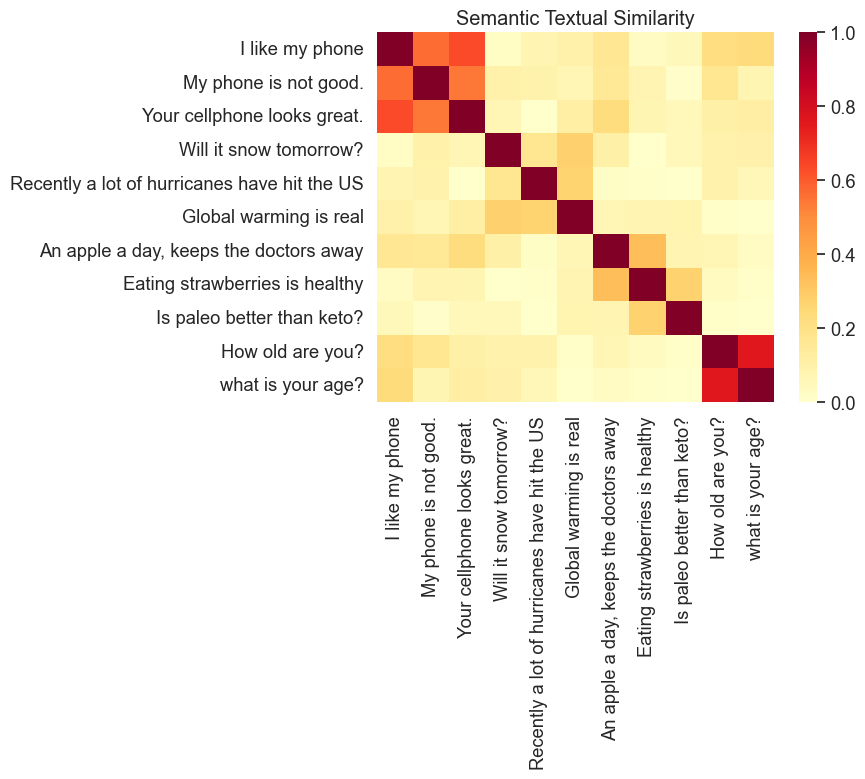

In [14]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
embeddings = []
for t in messages:
    emb = list(model.encode(t))
    embeddings.append(emb)

plot_similarity(messages, embeddings, 90)

In [15]:
def sim_two_sentences(s1, s2):
    emb1 = list(model.encode(s1))
    emb2 = list(model.encode(s2))
    sim = cosine_similarity_matrix(np.vstack([emb1, emb2]))
    return sim[0,1]

sts['mini_LM_score'] = np.vectorize(sim_two_sentences)(sts['sent1'], sts['sent2'])
sts.head(10)

,sent1,sent2,score,avg_bert_score,mini_LM_score
0,A girl is styling her hair.,A girl is brushing her hair.,0.5000,0.9767,0.8052
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,0.7200,0.9615,0.7886
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,1.0000,0.9191,0.9465
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,0.8400,0.9763,0.8820
4,A man is playing a harp.,A man is playing a keyboard.,0.3000,0.9472,0.3556
5,A woman is cutting onions.,A woman is cutting tofu.,0.3600,0.8787,0.5017
6,A man is riding an electric bicycle.,A man is riding a bicycle.,0.7000,0.9793,0.8074
7,A man is playing the drums.,A man is playing the guitar.,0.4400,0.9730,0.4757
8,A man is playing guitar.,A lady is playing the guitar.,0.4400,0.9519,0.6182
9,A man is playing a guitar.,A man is playing a trumpet.,0.3428,0.9588,0.5096


In [16]:
pc = scipy.stats.pearsonr(sts['score'], sts['mini_LM_score'])
print(f'Pearson correlation coefficient = {pc[0]}\np-value = {pc[1]}')

Pearson correlation coefficient = 0.9303740673726043
p-value = 1.4823857251915632e-22
